In [6]:
import datajoint as dj
from ibl_pipeline import behavior, ephys
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from ibl_pipeline.plotting import plotting_utils_ephys as putils

In [11]:
def get_sort_and_marker(align_event, sorting_var):

    if sorting_var == 'response - stim on':
        sort_by = 'trial_response_time + trial_start_time - trial_stim_on_time'
        if align_event == 'stim on':
            mark = sort_by
            label = 'response'
        elif align_event == 'response':
            mark = """trial_stim_on_time -
                      trial_response_time - trial_start_time"""
            label = 'stim on'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'feedback - stim on':
        sort_by = 'trial_feedback_time - trial_stim_on_time'
        if align_event == 'stim on':
            mark = sort_by
            label = 'feedback'
        elif align_event == 'feedback':
            mark = 'trial_stim_on_time - trial_feedback_time'
            label = 'stim on'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'feedback - response':
        sort_by = """trial_feedback_time -
                     trial_response_time - trial_start_time"""
        if align_event == 'response':
            mark = sort_by
            label = 'feedback'
        elif align_event == 'feedback':
            mark = """trial_response_time + trial_start_time -
                      trial_feedback_time"""
            label = 'response'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'trial_id':
        sort_by = 'trial_id'
        mark = None
        label = None
    else:
        raise NameError("""
            'Unknown sorting variable.\n
            It has to be one of the following:\n
            ["trial_id", \n
             "response - stim on", \n
             "feedback - stim on", \n
             "feedback - response"]'""")
    return sort_by, mark, label

In [94]:
def get_spike_times(trials, sorting_var, align_event,
                    sort_by=None,
                    mark=None):
    if sorting_var != 'trial_id':
        trials = (trials & 'event="{}"'.format(align_event)).proj(
            'trial_id', 'trial_spike_times', sort_by=sort_by, mark=mark)
        spk_times, marking_points = trials.fetch(
            'trial_spike_times', 'mark', order_by='sort_by')
    else:
        trials = (trials & 'event="{}"'.format(align_event)).proj(
            'trial_id', 'trial_spike_times', sort_by=sort_by)
        spk_times = trials.fetch(
            'trial_spike_times', order_by='sort_by')
        marking_points = None

    return spk_times, marking_points


def get_spike_times_trials(trials, sorting_var, align_event,
                           sort_by=None,
                           mark=None):

    trials_left = trials & 'trial_response_choice="CW"' & \
        'trial_signed_contrast < 0'
    trials_right = trials & 'trial_response_choice="CCW"' & \
        'trial_signed_contrast > 0'

    trials_incorrect = trials - trials_left.proj() - trials_right.proj()

    kargs = dict(
        sorting_var=sorting_var,
        align_event=align_event,
        sort_by=sort_by,
        mark=mark
    )

    spk_times_left, marking_points_left = get_spike_times(trials_left, **kargs)
    spk_times_right, marking_points_right = get_spike_times(trials_right, **kargs)
    spk_times_incorrect, marking_points_incorrect = \
        get_spike_times(trials_incorrect, **kargs)

    return spk_times_left, \
        marking_points_left, \
        spk_times_right, \
        marking_points_right, \
        spk_times_incorrect, \
        marking_points_incorrect


def create_raster_plot_combined(trials, align_event,
                                sorting_var='trial_id',
                                x_lim=[-10, 10],
                                show_plot=False):

    sort_by, mark, label = get_sort_and_marker(
        align_event, sorting_var
    )

    spk_times_left, marking_points_left, \
        spk_times_right, marking_points_right, \
        spk_times_incorrect, marking_points_incorrect = \
        get_spike_times_trials(
            trials, sorting_var, align_event, sort_by, mark)
    
    id_gap = len(trials) * 0.02
    
    if len(spk_times_incorrect):
        spk_times_all_incorrect = np.hstack(spk_times_incorrect)
        id_incorrect = [[i] * len(spike_time)
                        for i, spike_time in enumerate(spk_times_incorrect)]
        id_incorrect = np.hstack(id_incorrect)
    else:
        id_incorrect = [0]
    
    if len(spk_times_left):
        spk_times_all_left = np.hstack(spk_times_left)
        id_left = [[i + max(id_incorrect) + id_gap] * len(spike_time)
               for i, spike_time in enumerate(spk_times_left)]
        id_left = np.hstack(id_left)
    else:
        id_left = [max(id_incorrect)]
    
    if len(spk_times_right):
        spk_times_all_right = np.hstack(spk_times_right)
        id_right = [[i + max(id_left) + id_gap] * len(spike_time)
                for i, spike_time in enumerate(spk_times_right)]
        id_right = np.hstack(id_right)
    else:
        id_right = [max(id_right)]
    
    fig = plt.figure(dpi=150, frameon=False, figsize=[10, 5])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    
    if len(spk_times_left):
        ax.plot(spk_times_all_left, id_left, 'g.', alpha=0.5, markeredgewidth=0, label='left trials')
    if len(spk_times_right):
        ax.plot(spk_times_all_right, id_right, 'b.', alpha=0.5, markeredgewidth=0, label='right trials')
    
    if len(spk_times_incorrect):
        ax.plot(spk_times_all_incorrect, id_incorrect, 'r.', 
                alpha=0.5, markeredgewidth=0, label='incorrect trials')
    
    if sorting_var != 'trial_id':
        if len(spk_times_incorrect):
            ax.plot(marking_points_incorrect, range(len(spk_times_incorrect)) , 'r', label=label)
        if len(spk_times_left):
            ax.plot(marking_points_left, np.add(range(len(spk_times_left)), max(id_incorrect) + id_gap), 'g')
        if len(spk_times_right):
            ax.plot(marking_points_right, np.add(range(len(spk_times_right)), max(id_left) + id_gap), 'b')
        
    ax.set_axis_off()
    fig.add_axes(ax)

    # hide the axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # set the limits
    ax.set_xlim(x_lim[0], x_lim[1])
    y_lim = max(id_right) * 1.02
    ax.set_ylim(-2, y_lim)

    # save the figure with `pad_inches=0` to remove
    # any padding in the image
    import tempfile
    temp = tempfile.NamedTemporaryFile(suffix=".png")
    fig.savefig(temp.name, pad_inches=0)

    if not show_plot:
        plt.close(fig)

    import base64
    with open(temp.name, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    temp.close()
    return encoded_string, [0, y_lim], label

In [95]:
# create some plots for the legend
def get_legend(trials_type, legend_group):
    if trials_type == 'left':
        color = 'green'
    elif trials_type == 'right':
        color = 'blue'
    elif trials_type == 'incorrect':
        color = 'red'
    else:
        raise NameError(
            f"""
            Wrong trial type, has to be one of the following: \n
            "left", "right", "incorrect"
            """
        )
    if legend_group == 'spike':
        marker = 'markers'
    else:
        marker = 'lines'
      
    return go.Scatter(
        x=[5],
        y=[10],
        mode=marker,
        marker=dict(
            size=6,
            color=color,
            opacity=0.5
        ),
        name='{} time on<br>{} trials'.format(legend_group, trials_type),
        legendgroup=legend_group
    )


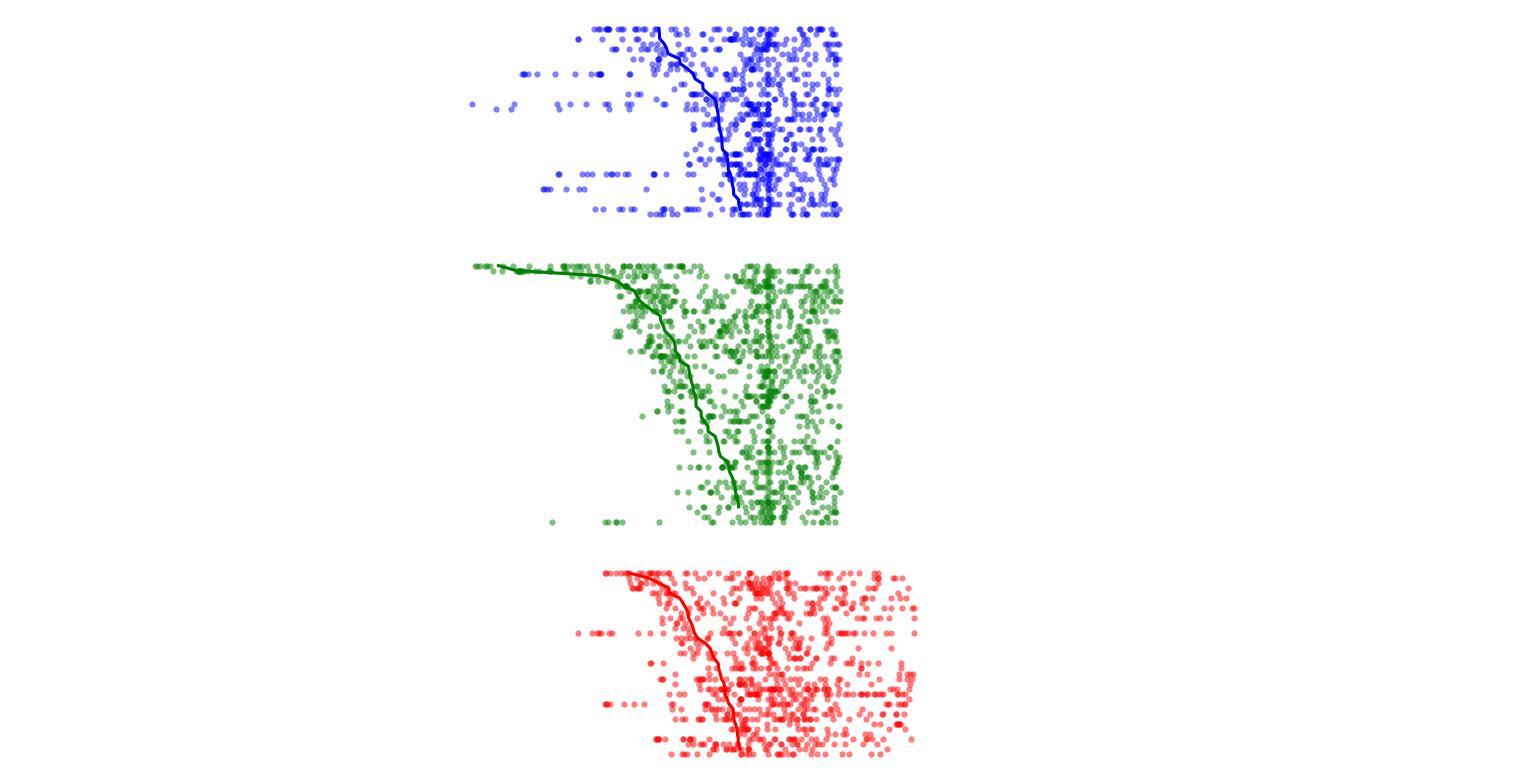

In [96]:
# Rasters aligned
cluster = ephys.Cluster & 'cluster_id=21'
trials_all = (behavior.TrialSet.Trial * ephys.TrialSpikes & cluster).proj(
    'trial_start_time', 'trial_stim_on_time', 'trial_response_time', 'trial_feedback_time',
    'trial_response_choice', 'trial_spike_times',
    trial_duration='trial_end_time-trial_start_time',
    trial_signed_contrast='trial_stim_contrast_right - trial_stim_contrast_left'
) & 'trial_duration < 5' & 'trial_response_choice!="No Go"'

trials_left = trials_all & 'trial_response_choice="CW"' & 'trial_signed_contrast < 0'
trials_right = trials_all & 'trial_response_choice="CCW"' & 'trial_signed_contrast > 0'
trials = trials_all & [trials_right.proj(), trials_left.proj()]
align_event = 'feedback'
encoded_string, y_lim, label = create_raster_plot_combined(
    trials_all, align_event, 'feedback - response', show_plot=True)

In [98]:
axis = go.Scatter(
    x=x_lim,
    y=y_lim,
    mode='markers',
    marker=dict(opacity=0),
    showlegend=False
)

legend_left = putils.get_legend('left', 'spike')
legend_right = putils.get_legend('right', 'spike')
legend_incorrect = putils.get_legend('incorrect', 'spike')

legend_mark_left = putils.get_legend('left', label)
legend_mark_right = putils.get_legend('right', label)
legend_mark_incorrect = putils.get_legend('incorrect', label)

layout = go.Layout(
    images=[dict(
      source='data:image/png;base64, ' + encoded_string.decode(),
      sizex=x_lim[1] - x_lim[0],
      sizey=y_lim[1] - y_lim[0],
      x=x_lim[0],
      y=y_lim[1],
      xref='x',
      yref='y',
      sizing='stretch',
      layer='below'
    )],
    width=580,
    height=370,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=40,
        t=80,
        pad=0
    ),
    title=dict(
        text='Raster, aligned to {}'.format(align_event),
        x = 0.21,
        y=0.87
    ),
    xaxis=dict(
        title='Time (sec)',
        range=x_lim,
        showgrid=False
    ), 
    yaxis=dict(
        title='Trial idx',
        range=y_lim,
        showgrid=False
    ),
#     template=dict( 
#         layout=dict(
#             plot_bgcolor="#fff"
#         )
#     )
)

data = [axis, legend_left, legend_right, legend_incorrect,
        legend_mark_left, legend_mark_right, legend_mark_incorrect]

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [176]:
import json
f = open("rasters.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()